# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for oue own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar ro our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Get data (10% of 10 food classes from food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-05-27 05:09:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   186MB/s    in 0.9s    

2023-05-27 05:09:27 (186 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os 

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data Inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print ("Testing images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images: 
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping calllback.


In [ ]:
# Create TensorBoard callback (functionalized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

> 🔑 **Note** : You can customize the directory where your TensorBoard logs (model trinaing metrics) get saved to whatever you like.

> The `log_dir` parameter we've created above is only one option

## Creating model using TensorFlow Hub

In the past we've used TensorFLow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFLow Hub.

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str) : A TensorFlow Hub feature extraction URL.
    num_classes (int) : Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output alyer with num_classes output neurons.
    """

  # Download the pretrained model and save it as keras layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = "feature_extraction_layer",  #freeze the already learned patterns
                                           input_shape=IMAGE_SHAPE+(3,)) 
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name = "output_layer")
  ])

  return model






### Creating & testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# create resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230527-074743
Epoch 1/5
24/24 [==============================] - 344s 15s/step - loss: 0.3185 - accuracy: 0.9413 - val_loss: 0.6524 - val_accuracy: 0.7860
Epoch 2/5
24/24 [==============================] - 336s 14s/step - loss: 0.2712 - accuracy: 0.9533 - val_loss: 0.6417 - val_accuracy: 0.7872
Epoch 3/5
24/24 [==============================] - 334s 14s/step - loss: 0.2267 - accuracy: 0.9680 - val_loss: 0.6357 - val_accuracy: 0.7856
Epoch 4/5
24/24 [==============================] - 339s 15s/step - loss: 0.1905 - accuracy: 0.9800 - val_loss: 0.6254 - val_accuracy: 0.7900
Epoch 5/5
24/24 [==============================] - 336s 14s/step - loss: 0.1660 - accuracy: 0.9853 - val_loss: 0.6243 - val_accuracy: 0.7904


Our transfer learning feature extractor model out performed all of the previous models we buil by hand...(substantially) and in a quicker training time and with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves

# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...

import matplotlib.pyplot as plt

#Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validaiton metrics.

  Args:
    history : TensorFlow History object.

  Returns:
    plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))


  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

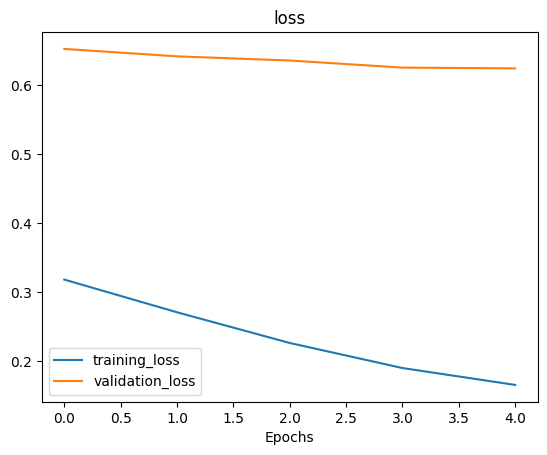

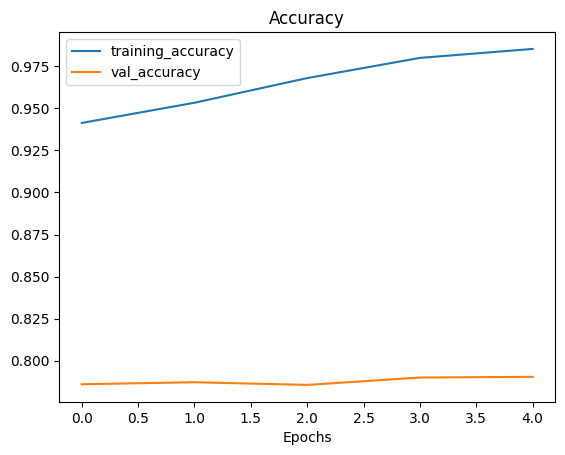

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Ectraction model

In [ ]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"] 
)

# fit efficientnet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                       experiment_name="efficientnameb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnameb0/20230527-094135
Epoch 1/5
24/24 [==============================] - 183s 8s/step - loss: 1.9302 - accuracy: 0.3760 - val_loss: 1.3413 - val_accuracy: 0.7088
Epoch 2/5
24/24 [==============================] - 179s 8s/step - loss: 1.0882 - accuracy: 0.7693 - val_loss: 0.8890 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 174s 8s/step - loss: 0.7756 - accuracy: 0.8427 - val_loss: 0.7097 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 166s 7s/step - loss: 0.6154 - accuracy: 0.8720 - val_loss: 0.6167 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 182s 8s/step - loss: 0.5210 - accuracy: 0.8867 - val_loss: 0.5626 - val_accuracy: 0.8628


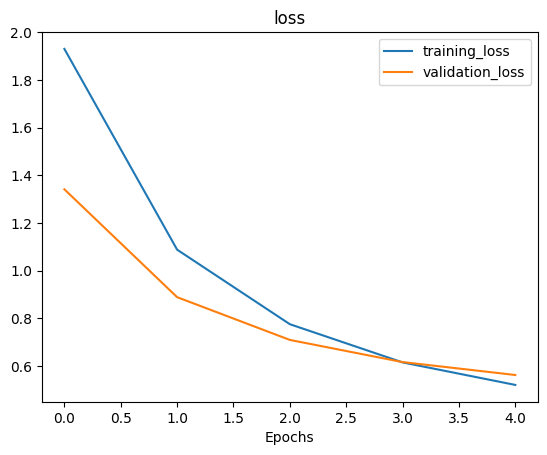

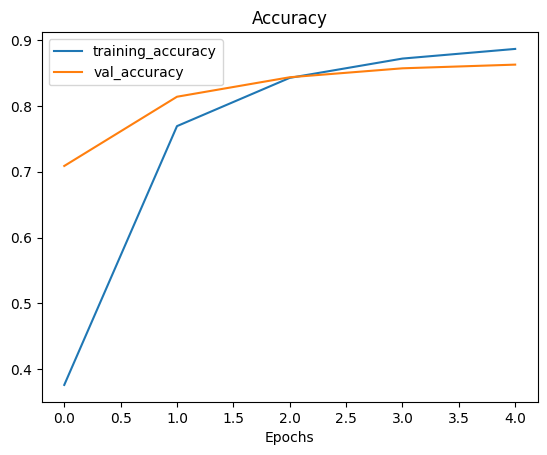

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature Extraction" transfer leraning**- use of prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes o food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

##Comparing our models results using TensorBoard

> 🔑 **Note** : When you upload things to TensorBoard.dev, yoy experiments are public. So if you're runnign private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data"\
  --one_shot 

In [ ]:
!tensorboard dev list

2023-05-27 10:14:08.242116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/XJy3yubwQrKGrlvmZx6nYw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   XJy3yubwQrKGrlvmZx6nYw
	Created              2023-05-27 10:10:25 (3 minutes ago)
	Updated              2023-05-27 10:10:28 (3 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7540308
Total: 1 experiment(s)


In [ ]:
# # Delete an experiment
# !tensorboard dev delete --experiment_id XJy3yubwQrKGrlvmZx6nYw

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list